In [608]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
from os.path import join
import torch
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [609]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from os.path import join as oj
import torch.utils.data as utils
from torchvision import datasets, transforms
import numpy as np
import os
import sys
pd.set_option('precision', 3)

In [610]:
trained_model_folder = '../img_models/'
fnames = sorted([oj(trained_model_folder, fname) for fname in os.listdir(trained_model_folder)]) 
# other models were trained badly


In [611]:
fnames

['../img_models/02207644335738013335.pkl.pkl',
 '../img_models/03362744720856087602.pkl.pkl',
 '../img_models/04145485044365807547.pkl.pkl',
 '../img_models/08506737881721818376.pkl.pkl',
 '../img_models/10257150655517666823.pkl.pkl',
 '../img_models/10351045417687343663.pkl.pkl',
 '../img_models/10414628053456841476.pkl.pkl',
 '../img_models/14053731481646180832.pkl.pkl',
 '../img_models/15210140284057052137.pkl.pkl',
 '../img_models/15225181760080858770.pkl.pkl',
 '../img_models/15245861755522025814.pkl.pkl',
 '../img_models/17220605648128863872.pkl.pkl',
 '../img_models/20346623323331576071.pkl.pkl',
 '../img_models/20687365607353173377.pkl.pkl',
 '../img_models/21630152084688012183.pkl.pkl',
 '../img_models/24488015587822747041.pkl.pkl',
 '../img_models/25108450010115205070.pkl.pkl',
 '../img_models/25121555661270586013.pkl.pkl',
 '../img_models/25658603706074410347.pkl.pkl',
 '../img_models/27403455112251015672.pkl.pkl',
 '../img_models/28383768182153564667.pkl.pkl',
 '../img_mode

In [612]:

results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in (fnames)] 
results = pd.concat(results_list, axis=1).T.infer_objects() # pandas dataframe w/ hyperparams and weights stored


#results = results[results.which_adversarial == "annotated"]
#results = results.drop(columns = ['model_weights']) # don't want this because too big

In [613]:
# results = results.drop(columns = ['model_weights']) # don't want this because too big

In [614]:
results.columns

Index(['losses_train', 'losses_test', 'accs_train', 'accs_test', 'cd',
       'model_weights', 'regularizer_rate', 'num_blobs'],
      dtype='object')

In [615]:
results['final_acc'] = [x[0] for x in results['accs_test']]
results['final_acc_train'] = [x[0] for x in results['accs_train']]

results['final_cd'] = [x[0] for x in results['cd']]
results['final_test_loss'] = [x[0] for x in results['losses_test']]
results['final_train_loss'] = [x[0] for x in results['losses_train']]

In [616]:
results = results.dropna()
results.reset_index(drop=True, inplace=True)

In [622]:
esults_save = results[['regularizer_rate','final_acc' ]].sort_values(by = ['regularizer_rate'])

In [623]:
esults_save.groupby(by = 'regularizer_rate').mean()

,final_acc
regularizer_rate,
0.0,0.040
0.1,4.116
1.0,1.477
10.0,19.227
100.0,2.270
200.0,0.070
300.0,6.900
500.0,9.560


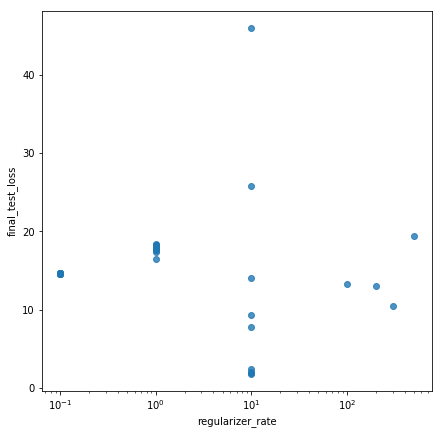

In [624]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log")
sns.regplot('regularizer_rate', 'final_test_loss',ax=ax, data=results, fit_reg=False);

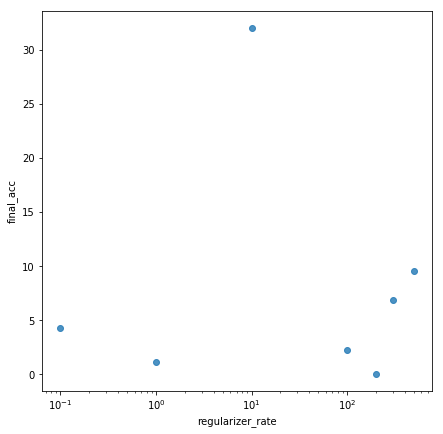

In [576]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log")
sns.regplot('regularizer_rate', 'final_acc',ax=ax, data=results, fit_reg=False);

In [577]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.conv2_drop = nn.Dropout2d()

        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc1(x))
        
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    def logits(self, x):
    
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc1(x))
        
        x = self.fc2(x)
        return x


In [578]:
kwargs = {'num_workers': 1, 'pin_memory': True}
test_x_tensor = torch.Tensor(np.load(oj("../data/ColorMNIST", "test_x.npy")))
test_y_tensor = torch.Tensor(np.load(oj("../data/ColorMNIST", "test_y.npy"))).type(torch.int64)
test_dataset = utils.TensorDataset(test_x_tensor,test_y_tensor) # create your datset
test_loader = utils.DataLoader(test_dataset,
        batch_size=64, shuffle=True, **kwargs) # create your dataloader



In [579]:
def test( model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    return(test_loss, 100.*correct / len(test_loader.dataset))
#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#     test_loss, correct, len(test_loader.dataset),
#     100. * correct / len(test_loader.dataset)))

In [580]:
test_x_tensor = torch.Tensor(np.load(oj("../data/ColorMNIST", "test_x.npy")))
test_y_tensor = torch.Tensor(np.load(oj("../data/ColorMNIST", "test_y.npy"))).type(torch.int64)
test_y_color= torch.Tensor(np.load(oj("../data/ColorMNIST", "test_y_color.npy"))).type(torch.int64)
test_dataset_digit = utils.TensorDataset(test_x_tensor,test_y_tensor) # create your datset
test_dataset_color = utils.TensorDataset(test_x_tensor,test_y_color) # create your datset
test_loader_digit = utils.DataLoader(test_dataset_digit,
        batch_size=256, shuffle=True, **kwargs) # create your dataloader
test_loader_color = utils.DataLoader(test_dataset_color,
        batch_size=256, shuffle=True, **kwargs) # create your dataloader



In [581]:
test_net = Net()
test_net = test_net.to(0)



In [582]:
results.loc[1].regularizer_rate

0.1

In [583]:
acc_color_list = []
loss_color_list = []
for i in range(len(results)):
    test_net.load_state_dict(results.model_weights[i])
    loss_col, acc_col = test(test_net, 0, test_loader_random, 0)
    acc_color_list.append(acc_col)
    loss_color_list.append(loss_col)
results["acc_random"] =[x for x in acc_color_list]
results["loss_random"] =[x for x in loss_color_list]               
               

In [584]:
results[['regularizer_rate',"acc_random"]].sort_values(by = ['regularizer_rate'])

,regularizer_rate,acc_random
5,0.0,18.30
1,0.1,21.82
4,1.0,20.87
6,10.0,15.32
0,100.0,12.99
3,200.0,11.44
2,300.0,13.21
7,500.0,15.72


In [587]:
acc_color_list = []
loss_color_list = []
for i in range(len(results)):
    test_net.load_state_dict(results.model_weights[i])
    loss_col, acc_col = test(test_net, 0, test_loader_color, 0)
    acc_color_list.append(acc_col)
    loss_color_list.append(loss_col)
results["acc_color"] =[x for x in acc_color_list]
results["loss_color"] =[x for x in loss_color_list]               
               


In [588]:
results[['regularizer_rate',"acc_color"]].sort_values(by = ['regularizer_rate'])

,regularizer_rate,acc_color
5,0.0,71.69
1,0.1,51.16
4,1.0,58.46
6,10.0,14.55
0,100.0,40.10
3,200.0,39.52
2,300.0,24.66
7,500.0,49.86
